# Vulnerability and fragility curves for GMMA

### Introduction for calculating damage and or damage states from fragility curves.

Start by using the matplotlib magic to allow us to display plots directly in the notebook. You can change which backend is used, but most of the time, you'll want to embed them inside the notebook.

In [1]:
%matplotlib inline

Now import the required modules to allow plotting, loading data, generating the curves and interacting with them.

In [2]:
import numpy as np
from scipy.stats import lognorm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn
seaborn.set_context("poster")

# Import widgets for interactive notebook
from IPython.html.widgets import interact, fixed, interactive
from IPython.html import widgets
from IPython.display import display

from StringIO import StringIO

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Define the parameters for the vulnerability and fragility curves. These are the parameters provided by UPD-ICE under the GMMA-RAP project. The parameters are for a cumulative lognormal distribution that describes the probability of a building being in a given damage state, or a higher damage state. The damage state descriptions are based on those from the HAZUS-MH Hurricane Model (see Vickery _et al._, 2006). The assumed damage ratio gives an indication of the likely repair cost for the given damage state (as a fraction of the total replacement cost). 

Rather than trying to load the data from a file (which may not be readily accessible), we create a file-like object to read the data into an array (more for demonstration than out of necessity). 

The values given here are directly from the UPD-ICE Technical Report.

In [3]:
fragilitycurves = StringIO("""Type,Mean,SD,Scale,Slight,SD,Scale,Moderate,SD,Scale,Extensive,SD,Scale,Complete,SD,Scale
C1-L-S,477.26,0.46,1.00000,209,0.23,1.00000,241,0.2,1.00000,277,0.17,1.00000,371,0.13,1.00000
C1-L-W,416.41,0.52,1.00000,132,0.17,1.00000,208,0.16,1.00000,240,0.14,1.00000,301,0.17,1.00000
C1-M,221.00,0.33,0.13333,144,0.17,0.133333,171,0.17,0.133333,218,0.22,0.133333,270,0.17,0.133333
CHB-L-S,469.00,0.44,1.00000,233,0.33,1.00000,260,0.25,1.00000,290,0.23,1.00000,323,0.17,1.00000
CHB-L-W,455.00,0.59,1.00000,164,0.15,1,188,0.19,1,230,0.22,1,324,0.17,1
CWS-L-S,398.00,0.16,1.00000,266,0.17,1.00000,311,0.2,1.00000,354,0.09,1.00000,379,0.07,1.00000
CWS-L-W,321.00,0.52,1.00000,139,0.34,1,162,0.3,1,218,0.29,1,263,0.31,1
MWS-L-S,398.00,0.16,1.00000,266,0.17,1.00000,311,0.2,1.00000,354,0.09,1.00000,379,0.07,1.00000
MWS-L-W,321.00,0.52,1.00000,139,0.34,1,162,0.3,1,218,0.29,1,263,0.31,1
N-L,136.00,0.20,1.00000,103,0.16,1,123,0.17,1,162,0.26,1,219,0.28,1
S1-L,379.10,0.61,1.00000,154,0.35,1,180.45,0.4,1,202.75,0.43,1,315.1,0.46,1
S1-M,180.00,0.24,0.13333,140,0.15,0.1333333,152,0.15,0.1333333,188,0.21,0.1333333,205,0.17,0.1333333
S3-L,387.00,0.37,1.00000,231,0.24,1,270,0.24,1,322,0.24,1,478,0.36,1
W1-L,176.00,0.09,1.00000,143,0.16,1,163,0.17,1,200,0.26,1,259,0.28,1
W3-L,95.31,0.25,1.00000,62,0.16,1,82,0.17,1,120,0.26,1,180,0.28,1
""")

The `scale` factor is applied to the loss curve for larger, engineered structures (predominantly high-rise buildings). This is based on the assumption that, for these structures, the only components that can suffer complete damage are the roof and window components. See Appendix A of _Development of Vulnerability Curves for Key Building Types in the Greater Metro Manila Area, Philippines_, UPD-Institute of Civil Engineering (2013). 

##### Building damage states

The damage states give a qualitative indication of the level of damage sustained to a buiding (or components of a building). The damage index quantifies this as a fraction of the complete replacement cost of the structure (component). 


| Damage state | Description                                |
|--------------|:-------------------------------------------|
| Negligible   | Little or no visible damage from the outside. No broken windows, or failed roof deck. Minimal loss of roof over, with no or very limited water penetration. |
| Slight       | Moderate roof cover that can be covered to prevent additional water ingress. One window, door or garage door broken. |
| Moderate     | Major roof damage, moderate window breakage. Minor roof sheathing failure. Some water damage to interior.            |
| Extensive    | Major window damage or roof sheathing loss. Major roof cover loss. Extensive damage to interior from water.          |
| Complete     | Complete roof failure and/or failure of wall frame. Loss of more than 50% of roof sheathing.                         |

The damage indices are building-specific. In some cases, the damage index for complete damage is < 1.0, which would be counterintuitive. For C1-M and S1-M, only window and roof components were considered, and so the damage index is scaled to reflect the proportional costs of those elements. 

| Type    | Negligible | Slight  | Moderate | Extensive | Complete |
|---------|------------|---------|----------|-----------|----------|
| C1-L-S  | 0.0003     | 0.0134  | 0.0981   | 0.185     | 0.4      |
| C1-L-W  | 0.0003     | 0.0134  | 0.0981   | 0.185     | 0.4      |
| C1-M    | 0.00074    | 0.00659 | 0.03025  | 0.07615   | 0.09975  |
| CHB-L-S | 0.0003     | 0.0134  | 0.0981   | 0.185     | 0.4      |
| CHB-L-W | 0.0003     | 0.0134  | 0.0981   | 0.185     | 0.4      |
| CWS-L-S | 0.000      | 0.01275  | 0.04875   | 0.1125    | 0.4625   |
| CWS-L-W | 0.000      | 0.01275  | 0.04875   | 0.1125    | 0.4625   |
| MWS-L-S | 0.000      | 0.01275  | 0.04875   | 0.1125    | 0.4625   |
| MWS-L-W | 0.000      | 0.01275  | 0.04875   | 0.1125    | 0.4625   |
| N-L     | 0.003      | 0.031   | 0.12     | 0.283     | 1.000    |
| S1-L    | 0.000      | 0.01254 | 0.067375 | 0.165     | 0.55     |
| S1-M    | 0.000      | 0.011   | 0.049    | 0.089     | 0.133    |
| S3-L    | 0.0003     | 0.0161  | 0.1169   | 0.24      | 0.55     |
| W1-L    | 0.003      | 0.031   | 0.12     | 0.283     | 1.000    |
| W3-L    | 0.003      | 0.031   | 0.12     | 0.283     | 1.000    |

In [4]:
damageindices = StringIO("""Type,Negligible,Slight,Moderate,Extensive,Complete
C1-L-S,0.0003,0.0134,0.0981,0.185,0.4
C1-L-W,0.0003,0.0134,0.0981,0.185,0.4
C1-M,0.00074,0.00659,0.03025,0.07615,0.09975
CHB-L-S,0.0003,0.0134,0.0981,0.185,0.4
CHB-L-W,0.0003,0.0134,0.0981,0.185,0.4
CWS-L-S,0,0.01275,0.04875,0.1125,0.4625
CWS-L-W,0,0.01275,0.04875,0.1125,0.4625
MWS-L-S,0,0.01275,0.04875,0.1125,0.4625
MWS-L-W,0,0.01275,0.04875,0.1125,0.4625
N-L,0.003,0.031,0.12,0.283,1
S1-L,0,0.01254,0.067375,0.165,0.55
S1-M,0,0.011,0.049,0.089,0.133
S3-L,0.0003,0.0161,0.1169,0.24,0.55
W1-L,0.003,0.031,0.12,0.283,1
W3-L,0.003,0.031,0.12,0.283,1
""")

We need to load the data that describes the damage and fragility functions. This is stored in a CSV format (above), so we'll use [numpy.genfromtxt](http://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html) to read it in and create a 2-d array that can be used to plot up the information. 

We need to first define the structure of the data, since the present format contains duplicate field names in the file header. Once that's done, we can then load it up. 

In [5]:
FCOLNAMES = ['BuildingType', 'Vuln_mu', 'Vuln_sd', 'Vuln_scale',
            'S_mu','S_sd','S_scale',
            'M_mu','M_sd','M_scale',
            'E_mu','E_sd','E_scale',
            'C_mu','C_sd','C_scale']

FCOLTYPES = ['|S7', 'f8', 'f8', 'f8',
            'f8', 'f8', 'f8',
            'f8', 'f8', 'f8',
            'f8', 'f8', 'f8',
            'f8', 'f8', 'f8']

DCOLNAMES = ["BuildingType", "Negligible", "Slight", 
             "Moderate", "Extensive", "Complete"]
DCOLTYPES = ["|S7", "f8", "f8", "f8", "f8", "f8"]

fdtype = np.dtype({'names':FCOLNAMES, 'formats':FCOLTYPES})
ddtype = np.dtype({'names':DCOLNAMES, 'formats':DCOLTYPES})

delimiter = ','
skip_header = 1
usecols = tuple(range(16))

Notice here I'm using the previously defined `StringIO` object as a file object. Saves the hassle of trying to select a file (which requires importing additional notebooks). This means that whenever you run the code snippet below, you **must** run the code snippet that defines the `StringIO` object above. Reading the `StringIO` object puts the pointer at the end of the buffer, so it'll raise a `StopIteration` exception. 

In [6]:
curvedata = np.genfromtxt(fragilitycurves, dtype=fdtype, delimiter=delimiter, 
                     skip_header=skip_header, usecols=usecols, 
                     autostrip=True)
damagedata = np.genfromtxt(damageindices, dtype=ddtype, delimiter=delimiter,
                          skip_header=skip_header, usecols=tuple(range(6)),
                          autostrip=True)

bldtypes = curvedata['BuildingType'].tolist()
nsim = 100000

Store the parameters of the damage and fragility curves in a dict, keyed by the name of the building type. 

The parameters define the cumulative lognormal distribution:

$F_V(v;\mu,\sigma) = \Phi\bigg(\frac{\ln v - \mu}{\sigma}\bigg)$

Note that [`scipy.stats`](https://docs.scipy.org/doc/scipy-0.15.1/reference/stats.html) uses fixed names for the parameters to all the continuous distributions. This means the mean of the distribution ($\mu$) defines the `scale` parameter, and the standard deviation ($\sigma$) defines the `shape` parameter. 

(Precisely, if $log(x)$ is normally distributed with mean $\mu$ and variance $\sigma^2$, then $x$ is log-normally distributed with `shape` parameter $\sigma$ and `scale` parameter $\exp(\mu)$ )

In [7]:
curves = dict()
damageindex = dict()
for i, t in enumerate(bldtypes):
    v = dict()
    d = dict()
    v['vloc'] = curvedata['Vuln_mu'][i]
    v['vshape'] = curvedata['Vuln_sd'][i]
    v['vscale'] = curvedata['Vuln_scale'][i]
    
    v['sloc'] = curvedata['S_mu'][i]
    v['sshape'] = curvedata['S_sd'][i]
    v['sscale'] = curvedata['S_scale'][i]
    
    v['mloc'] = curvedata['M_mu'][i]
    v['mshape'] = curvedata['M_sd'][i]
    v['mscale'] = curvedata['M_scale'][i]  
    
    v['eloc'] = curvedata['E_mu'][i]
    v['eshape'] = curvedata['E_sd'][i]
    v['escale'] = curvedata['E_scale'][i]
    
    v['cloc'] = curvedata['C_mu'][i]
    v['cshape'] = curvedata['C_sd'][i]
    v['cscale'] = curvedata['C_scale'][i]

    curves[t] = v
    damageindex[t] = np.array([damagedata['Negligible'][i], damagedata['Slight'][i], damagedata['Moderate'][i],
                              damagedata['Extensive'][i],damagedata['Complete'][i]])
    

#### Fitting the derived vulnerablity model

We use [least squares fitting](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.leastsq.html#scipy.optimize.leastsq) to fit the parameters of the derived loss curve. These functions define the calculation of residuals, then execute the least squares minimisation to determine the shape & location parameters for the cumulative lognormal distribution. 

In [8]:
def residuals(params, data, scale):
    x = np.arange(0., 361, 1.)
    return data - scale * lognorm.cdf(x, params[0], scale=params[1])

from scipy.optimize import leastsq
def minimise(data, scale, shape, loc):
    plsq = leastsq(residuals, [shape, loc], args=(data, scale))
    return plsq[0]

#### Monte-Carlo sampling to calculate damage ratio

Define a simple function to calculate the losses using monte carlo simulation. We create $10^5$ random samples of damage states, and assign a cost to each based on the assumed damage ratios defined above (from HAZUS-MH).

In [9]:
def probloss(cdfs, di):
    """
    Calculate a damage index for a population of buildings, given the probability of a 
    set of damage states (`cdfs`) and the damage index (`di`) associated with each damage
    state.
    
    Randomly sample from the distribution of different damage states and assign a cost
    to each, based on the damage indices. 
    
    :param cdfs: `numpy.ndarray` of cumulative distributions for the damage states
    :param di: `numpy.ndarray` of damage indices for the damage states.
    """
    
    u = np.random.uniform(0., 1., nsim)
    s, m, e, c = cdfs
    ndi, sdi, mdi, edi, cdi = di
    loss = np.ones(nsim) * ndi
    np.putmask(loss, ((u<=s) & (u>m)), sdi)
    np.putmask(loss, ((u<=m) & (u>e)), mdi)
    np.putmask(loss, ((u<=e) & (u>c)), edi)
    np.putmask(loss, u<=c, cdi)
    
    return loss

This function uses the method as reported by UPD-ICE to calculate the damage ratio. 

In [10]:
def probloss_upd(cdfs, di):
    """
    Determine the vulnerability as described in the UPD-ICE report for GMMA RAP. 
    We are attempting to replicate the curves reported by UPD-ICE. 
    
    In this method, a damage multiplier is multiplied to the probability of exceedance
    to arrive at the damage for a certain damage state. For each wind speed, the damage 
    index is computed by summing the damage for all damage states. 
    
    :param cdfs: `numpy.ndarray` of cumulative distribution values for damage states.
    :param di: `numpy.ndarray` of damage indices for damage states (including negligible damage).
    
    :returns: Damage ratio (should be between 0 and 1).
    
    """
    
    n = 1. 
    a = np.concatenate([[n], cdfs])
    loss = np.dot(a, di)
    
    return loss

Define a function to loop over all wind speeds and evaluate the damage ratio, given the probabilities of damage states and corresponding damage indices. 

In [11]:
def damage(v, curves, dmgindex):
    
    v = np.arange(0, 361., 1.)
    dmg_mean = np.zeros(len(v))
    dmg_sd = np.zeros(len(v))
    
    for i, x in enumerate(v):
        scdf = lognorm.cdf(x, curves['sshape'], scale=curves['sloc'])
        mcdf = lognorm.cdf(x, curves['mshape'], scale=curves['mloc'])
        ecdf = lognorm.cdf(x, curves['eshape'], scale=curves['eloc'])
        ccdf = lognorm.cdf(x, curves['cshape'], scale=curves['cloc'])
        probs = [scdf, mcdf, ecdf, ccdf]
        loss = probloss(probs, dmgindex)
        dmg_mean[i] = np.mean(loss)
        dmg_sd[i] = np.std(loss)
        
    return dmg_mean, dmg_sd

In [12]:
def damage_upd(v, curves, dmgindex):
    
    v = np.arange(0, 361., 1.)
    dmg_upd = np.zeros(len(v))
    for i, x in enumerate(v):
        scdf = lognorm.cdf(x, curves['sshape'], scale=curves['sloc'])
        mcdf = lognorm.cdf(x, curves['mshape'], scale=curves['mloc'])
        ecdf = lognorm.cdf(x, curves['eshape'], scale=curves['eloc'])
        ccdf = lognorm.cdf(x, curves['cshape'], scale=curves['cloc'])
        probs = [scdf, mcdf, ecdf, ccdf]
        dmg_upd[i] = probloss_upd(probs, dmgindex)
        
    return dmg_upd

In [13]:
def plotdamage(ax, curves, windspeed, dmgindex):
    v = np.arange(0, 361., 1.)
    
    dmg_mean, dmg_sd = damage(v, curves, dmgindex)
    
    dmg_lower = np.max(np.array([np.zeros(len(v)), dmg_mean - dmg_sd]),axis=0)
    dmg_upper = np.min(np.array([np.ones(len(v)), dmg_mean + dmg_sd]),axis=0)
    widx = np.where(v==windspeed)[0]
    dmg_mean_ws = dmg_mean[widx]
    dmg_sd_ws = dmg_sd[widx]
    ax.plot(v, dmg_mean, 'b', linewidth=2., 
             label="Damage ratio (derived): %.3f"%dmg_mean_ws)
    ax.fill_between(v, dmg_lower, dmg_upper, facecolor='b', alpha=0.2)   
       
    ax.set_xlim((0,360))
    ax.set_xticks(np.arange(0, 361., 30))
    ax.set_ylim((0,1))
    ax.set_ylabel('Damage ratio')
    ax.axvline(windspeed, color='k',linestyle=':')
    
    if dmg_mean_ws < 0.95:
        ax.text(windspeed+2, dmg_mean_ws+0.05, "%.3f"%dmg_mean_ws, 
                 fontsize='x-small', color='b', ha='left', va='center')
    else:
        ax.text(windspeed+2, dmg_mean_ws-0.05, "%.3f"%dmg_mean_ws, 
                 fontsize='x-small', color='b', 
                 ha='left', va='center')
        
    xx = np.where(dmg_mean<=0.5)[0][-1]
    loc = v[xx]
    
    p = minimise(dmg_mean, curves['vscale'], curves['vshape'], loc)
    pval = lognorm.cdf(windspeed, p[0], scale=p[1])
    
    ax.plot(v, curves['vscale']*lognorm.cdf(v, p[0], scale=p[1]), 'r', 
             linewidth=2., linestyle=':', label="Fitted model: %.3f"%pval)
    
    fitstr = """Fitted parameters:
    $\sigma$ : %.4f
    $\mu$ : %.1f"""%(p[0], p[1])
    ax.text(15, 0.45, fitstr, 
             bbox=dict(facecolor='white', alpha=0.5),
             ha='left', va='top', color='r')

    return dmg_mean, dmg_sd

In [19]:
def plotdamage_upd(ax, curves, windspeed, dmgindex):
    v = np.arange(0, 361., 1.)
    vcdf = curves['vscale'] * lognorm.cdf(v, curves['vshape'], 
                                          scale=curves['vloc'])
    widx = np.where(v==windspeed)[0]
    ax.plot(v, vcdf, '0.5', linewidth=2., label="Damage model (UPD-ICE): %.3f"%vcdf[widx])
    
    #dmg = damage_upd(v, curves, dmgindex)
    #ax.plot(v, dmg, linewidth=2., color='g', label="Damage model (UPD-ICE) - cumulative: %.3f"%dmg[widx])
    
    l = ax.legend(loc=2,frameon=True)
    
    param_str = """UPD-ICE parameters:
    $\sigma$ : %.4f
    $\mu$ : %.1f"""%(curves['vshape'], curves['vloc'])
    
    ax.text(15, 0.25, param_str, 
             bbox=dict(facecolor='white'),
             ha='left', va='top', color='k')

This function calculates a histogram, based on the likely distribution of buildings being in different damage states. We take a random sample of 100,000 'buildings' and assign a damage state based on the fragility curves for the given wind speed $v$. 

In [20]:
def problosshist(ax, curves, v, dmgindex):
    """
    Plot a histogram of the distribution of damage states. 
    
    """
    scdf = lognorm.cdf(v, curves['sshape'], scale=curves['sloc'])
    mcdf = lognorm.cdf(v, curves['mshape'], scale=curves['mloc'])
    ecdf = lognorm.cdf(v, curves['eshape'], scale=curves['eloc'])
    ccdf = lognorm.cdf(v, curves['cshape'], scale=curves['cloc'])
    probs = [scdf, mcdf, ecdf, ccdf]
    loss = probloss(probs, dmgindex)
    bins = np.concatenate([dmgindex, [1.1]])
    losshist, bins = np.histogram(loss, bins=bins)
    ax.bar(np.arange(5), losshist, align='center')
    ax.set_xlim((-0.5, 4.5))
    
    axyl = ax.get_yticklabels()
    ax.set_xticklabels(['','Negligible', 'Slight', 'Moderate', 'Extensive', 'Complete'],
                       ha='center')
    ax.set_ylim((0,nsim))
    for t in axyl:
        t.set_rotation('vertical')
        
    ax.set_title("Distribution of damage state")

Now, we define a function to plot the fragility curves for a selected building type, and alongside it the corresponding damage curve. 

We add the loss curve as defined by UPD-ICE, a derived loss curve, based on monte-carlo sampling of the fragility, and a fitted curve, based on the derived curve. 

In [21]:
def plotcurve(buildingtype, windspeed, seed):
    np.random.seed(seed)
    bldcurves = curves[buildingtype]
    dmgindex = damageindex[buildingtype]
    v = np.arange(0, 361., 1.)
    
    vcdf = bldcurves['vscale'] * lognorm.cdf(v, bldcurves['vshape'], 
                                              scale=bldcurves['vloc'])
    
    scdf = lognorm.cdf(v, bldcurves['sshape'], scale=bldcurves['sloc'])
    mcdf = lognorm.cdf(v, bldcurves['mshape'], scale=bldcurves['mloc'])
    ecdf = lognorm.cdf(v, bldcurves['eshape'], scale=bldcurves['eloc'])
    ccdf = lognorm.cdf(v, bldcurves['cshape'], scale=bldcurves['cloc'])

    # Set up the figure canvas:
    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(2,6)
    
    ax1 = plt.subplot(gs[0:1,0:4])
    ax2 = plt.subplot(gs[-1,0:4])
    ax3 = plt.subplot(gs[0:2,4:])

    # Plot the fragility curves:
    ax1.fill_between(v, 0, ccdf, facecolor='k', alpha=0.25)
    ax1.plot(v, ccdf, 'k', linewidth=1.)
    ax1.fill_between(v, ccdf, ecdf, facecolor='r', alpha=0.25)
    ax1.plot(v, ecdf, 'r', linewidth=1.)
    ax1.fill_between(v, ecdf, mcdf, facecolor='b', alpha=0.25)
    ax1.plot(v, mcdf, 'b', linewidth=1.)
    ax1.fill_between(v, mcdf, scdf, facecolor='g', alpha=0.25)
    ax1.plot(v, scdf, 'g', linewidth=1.)
    
    # Add annotations:
    bbox = dict(facecolor='white', alpha=0.5)
    cypos = lognorm.cdf(windspeed, bldcurves['cshape'], scale=bldcurves['cloc']) 
    ax1.plot([windspeed, windspeed], [0,cypos], color='k', 
             label="Complete: %.3f"%cypos)
    
    if cypos > 0.05:
        ax1.text(windspeed+2, cypos/2., "%.3f"%cypos, fontsize='small',
                 color='k', ha='left', va='center', bbox=bbox)
        
    eypos = lognorm.cdf(windspeed, bldcurves['eshape'], scale=bldcurves['eloc']) 
    ax1.plot([windspeed, windspeed], [cypos,eypos], color='r', 
             label="Extensive: %.3f"%(eypos - cypos))
    
    if (eypos - cypos) > 0.05:
        ax1.text(windspeed+2, (cypos+eypos)/2., "%.3f"%(eypos), 
                 fontsize='small',color='r', ha='left', va='center', bbox=bbox)
        
    mypos = lognorm.cdf(windspeed, bldcurves['mshape'], scale=bldcurves['mloc']) 
    ax1.plot([windspeed, windspeed], [eypos,mypos], color='b', 
             label="Moderate: %.3f"%(mypos - eypos))
    if (mypos - eypos) > 0.05:
        ax1.text(windspeed+2, (mypos+eypos)/2., "%.3f"%(mypos), 
                 fontsize='small',color='b', ha='left', va='center', bbox=bbox)
        
    sypos = lognorm.cdf(windspeed, bldcurves['sshape'], scale=bldcurves['sloc']) 
    ax1.plot([windspeed, windspeed], [mypos,sypos], color='g', 
             label="Slight: %.3f"%(sypos - mypos))
    if (sypos - mypos) > 0.05:
        ax1.text(windspeed+2, (sypos+mypos)/2., "%.3f"%(sypos), 
                 fontsize='small',color='g', ha='left', va='center', bbox=bbox)
    
    ax1.plot([windspeed, windspeed], [sypos,1.0], color='orange', 
             label="No damage: %.3f"%(1.-sypos))
    if sypos<0.95:
        ax1.text(windspeed+2, (sypos+1.)/2., "%.3f"%(1.-sypos), 
                 fontsize='small',color='brown', ha='left', va='center', bbox=bbox)
    
    # Arrange the axis limits, labels, etc.
    ax1.set_xlim((0,360))
    ax1.set_xticks(np.arange(0, 361., 30))
    ax1.set_ylim((0,1))
    ax1.set_ylabel(r"$ P(D \geq ds) $")
    ax1.set_xlabel("Wind speed (km/h)")
    ax1.axvline(windspeed, color='k',linestyle=':')
    ax1.grid(True)
    
    l = ax1.legend(loc=2,frameon=True,)
        
    ax1.set_title("Probability of damage states")
    
    # Add the other plots:
    problosshist(ax3, bldcurves, windspeed, dmgindex)
    plotdamage(ax2, bldcurves, windspeed, dmgindex)
    plotdamage_upd(ax2, bldcurves, windspeed, dmgindex)
    
    ax2.grid(True)
    ax2.set_title("Building damage ratio - %s"%buildingtype)
    fig.tight_layout()

Plot the curves for a selected building type. Users can vary the wind speed to observe the probability of that building type being in one of the damage states. 

The labels in the legend indicate the probability of the building type being in the given damage state. The text annotations indicate the probability of exceeding the damage state - that is, the building type is in that damage state, or a higher damage state. 

On the right is a bar chart counting the number of instances (out of a sample of 100,000) of each damage state. It's effectively representing the labels in the legend in a graphical manner. 

In the lower panel, the derived vulnerability curve (blue), the published vulnerability curve (grey) and one based on the reported method of calculating the damage ratio (green). The derived curve includes the +/- 1 standard deviation range (blue band), plus a fitted lognormal cumulative distribution (red), based on the derived curve.

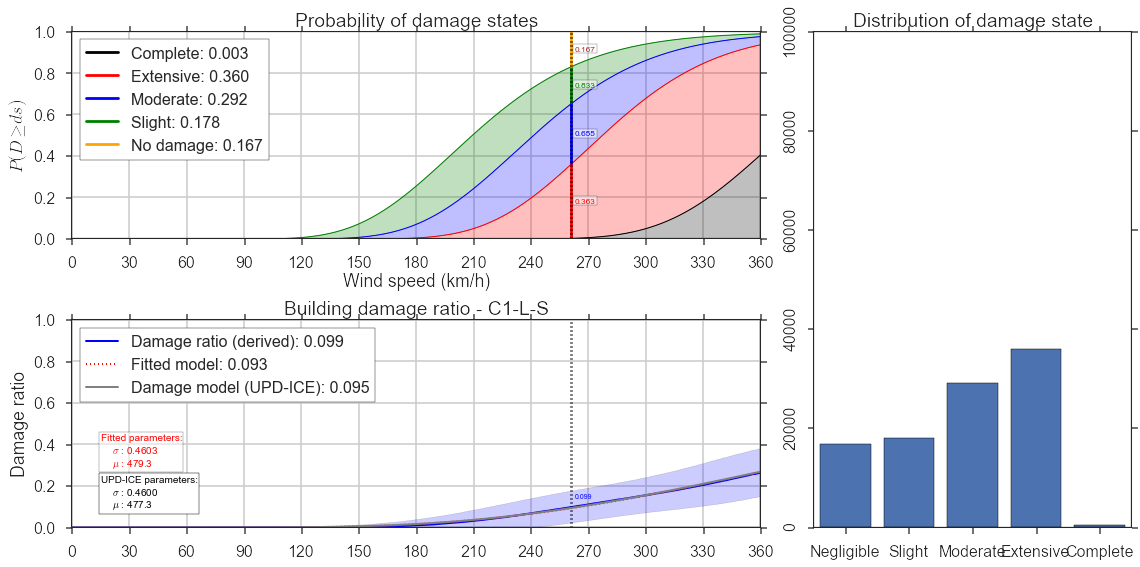

In [22]:
seed = 10574

# Drop down menu to select the building type:
bldselect = widgets.Dropdown(options=bldtypes, value=bldtypes[0],
                             description="Building type")

# Slider widget to set the wind speed:
windselect = widgets.FloatSlider(min=0.0, max=360., step=1., value=180., 
                                 description="Wind speed (km/h)" )

w = interactive(plotcurve, 
                buildingtype=bldselect, 
                windspeed=windselect, 
                seed=fixed(seed))
display(w)

Now we cycle through all available building types and fit a lognormal cdf to the derived damage curve. These can then be mapped to the corresponding building types in the full (>100) suite of building type & height combinations used in GMMA RAP to evaluate impacts to the built environment. The shape parameter should correspond to the 'sd' field in the suite of curves, and the scale corresponds to the 'mean' field.

In [18]:
v = np.arange(0, 361., 1.)    
newcurves = dict()
print "Building type: shape  : scale  : UPD-ICE shape : UPD-ICE scale"
print "-------------------------------------------------------------- "
for bldtype in bldtypes:

    bldcurves = curves[bldtype]
    di = damageindex[bldtype]
    vcdf = bldcurves['vscale'] * lognorm.cdf(v, bldcurves['vshape'], 
                                              scale=bldcurves['vloc'])
    dmg_mean, dmg_sd = damage( v, bldcurves, di)
    xx = np.where(dmg_mean<=0.5)[0][-1]
    loc = v[xx]
    p = minimise(dmg_mean, bldcurves['vscale'], bldcurves['vshape'], loc)
    print "{0:<13s}: {1:.5f}: {2:<7.2f}: {3:14.2f}: {4:<10.2f}".format(bldtype, p[0], p[1], 
                                                                       bldcurves['vshape'], bldcurves['vloc'])
    newcurves[bldtype] = {'vshape':p[0], 'vloc':p[1]}


Building type: shape  : scale  : UPD-ICE shape : UPD-ICE scale
-------------------------------------------------------------- 
C1-L-S       : 0.46049: 479.35 :           0.46: 477.26    
C1-L-W       : 0.48363: 403.91 :           0.52: 416.41    
C1-M         : 0.43101: 248.30 :           0.33: 221.00    
CHB-L-S      : 0.38339: 423.32 :           0.44: 469.00    
CHB-L-W      : 0.58518: 450.05 :           0.59: 455.00    
CWS-L-S      : 0.20857: 452.15 :           0.16: 398.00    
CWS-L-W      : 0.60730: 394.79 :           0.52: 321.00    
MWS-L-S      : 0.20777: 451.61 :           0.16: 398.00    
MWS-L-W      : 0.60718: 394.83 :           0.52: 321.00    
N-L          : 0.34572: 194.74 :           0.20: 136.00    
S1-L         : 0.72482: 425.84 :           0.61: 379.10    
S1-M         : 0.23356: 177.59 :           0.24: 180.00    
S3-L         : 0.44858: 475.07 :           0.37: 387.00    
W1-L         : 0.32824: 234.13 :           0.09: 176.00    
W3-L         : 0.37887: 155.43 : 

We'll plot all the curves together to see how the derived curves compare with the reported curves.

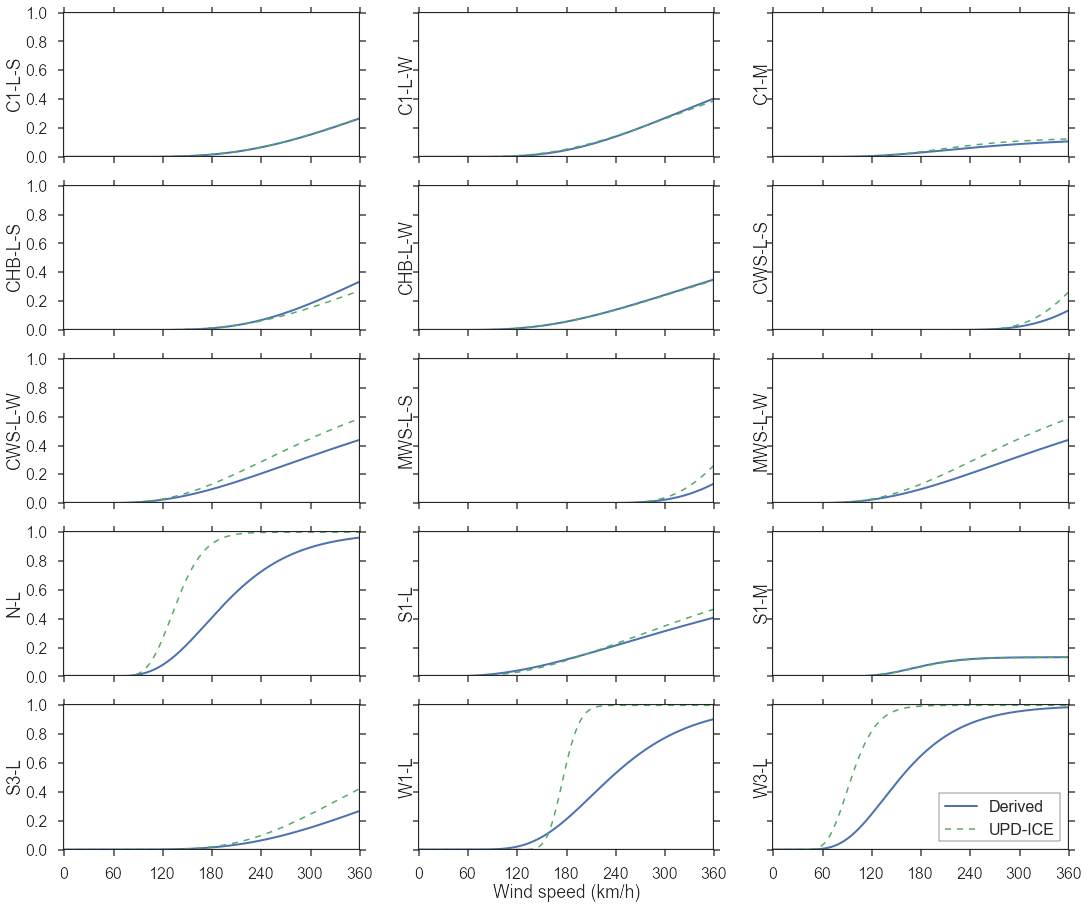

In [23]:
fig, axes = plt.subplots(len(bldtypes)/3, 3,sharex=True,sharey=True,figsize=(18,15))
x = np.arange(0, 360., 1.)

for ax, bldtype in zip(axes.ravel(), bldtypes):
    bldcurves = curves[bldtype]
    ncurves = newcurves[bldtype]
    vcdf = bldcurves['vscale'] * lognorm.cdf(x, bldcurves['vshape'], scale=bldcurves['vloc'])
    ncdf = bldcurves['vscale'] * lognorm.cdf(x, ncurves['vshape'], scale=ncurves['vloc'])
    ax.plot(x, ncdf, linewidth=2, label="Derived")
    ax.plot(x, vcdf, linewidth=1.5, linestyle='--',label="UPD-ICE")
    ax.set_ylabel(bldtype)
    
    ax.set_xlim((0,360))
    ax.set_xticks(np.arange(0, 361., 60))
    ax.set_ylim((0,1))

axes.ravel()[-2].set_xlabel("Wind speed (km/h)")
l = ax.legend(loc=0, frameon=True,)


Most of the derived models closely match the reported models. Curves where there is little damage below 240 km/h result in a poorer match, largely because there are fewer non-zero data points to fit against. There may be opportunity to review the underlying fragility curves to consider the level of damage sustained at high wind speeds. 

Also there are some building types where the damage index assigned to a complete damage state is not 1.0. Excluding those building types where only damage to windows and roofs are considered, this will lead to situations where the complete damage state is reached throughout a population of buildings, but the damage index is not 1.0. 

The W3-L, W1-L and N-L buildings are significantly different from the reported curves. This is because the derived curves were considered too strong and replaced with empirical curves based on discussion with local builders & carpenters. It could be recommended to fit fragility curves to these empirical damage curves. 

This document was written in an IPython notebook. The raw notebook can be downloaded [here](https://github.com/wcarthur/notebooks/blob/master/Vulnerability%20and%20fragility%20curves%20for%20GMMA.ipynb). See also [nbviewer](http://nbviewer.ipython.org/github/wcarthur/notebooks/blob/master/Vulnerability%20and%20fragility%20curves%20for%20GMMA.ipynb) for an online static view.